In [1]:
from airsenal.framework.bpl_interface import *
from airsenal.framework.utils import *

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# query results table and convert to pandas df
rows = []

results = session.query(Result).all()
for result in results:
    row = {}
    row['gameweek'] = result.fixture.gameweek
    row['season'] = result.fixture.season
    row['home_team'] = result.fixture.home_team
    row['away_team'] = result.fixture.away_team
    row['home_goals'] = result.home_score
    row['away_goals'] = result.away_score
    rows.append(row)

df = pd.DataFrame(rows)

# order results by season then gameweek
df = df.sort_values(by=['season', 'gameweek'])
df = df.reset_index(drop=True)

# ordered list of seasons and dictionary to convert
# season to index, where 0 is the oldest season in
# our data
seasons = sorted(df["season"].unique())
season_indices = {season: idx 
                  for idx, season in enumerate(seasons)}


# multi-season gw index, where 1 is oldest gameweek
# in our data
df["gw_index"] = df["gameweek"] + 38 * df["season"].replace(season_indices)

# for stan model will need to convert team names to an index
teams = list(set(df["home_team"]).union(set(df["away_team"])))
team_indices = {team: i + 1 for i, team in enumerate(teams)}

df

,gameweek,season,home_team,away_team,home_goals,away_goals,gw_index
0,1,1617,CHE,WHU,2,1,1
1,1,1617,BOU,MUN,1,3,1
2,1,1617,ARS,LIV,3,4,1
3,1,1617,HUL,LEI,2,1,1
4,1,1617,BUR,SWA,0,1,1
...,...,...,...,...,...,...,...
1215,8,1920,WHU,CRY,1,2,122
1216,8,1920,ARS,BOU,1,0,122
1217,8,1920,MCI,WOL,0,2,122
1218,8,1920,SOU,CHE,1,4,122


In [3]:
# functions to get a number of gameweeks from starting point
def select_n_gw_before(gw_index, n):
    """return n gameweeks of data before (and not including)
    the gameweek with index gw_index"""
    cut_future = df["gw_index"] < gw_index
    cut_past = df["gw_index"] >= gw_index - n
    return df[cut_future & cut_past]

display(select_n_gw_before(4, 2))

def select_n_gw_from(gw_index, n):
    """return n gameweeks of data from (and including)
    the gameweek with index gw_index"""
    cut_future = df["gw_index"] < gw_index + n
    cut_past = df["gw_index"] >= gw_index
    return df[cut_future & cut_past]

display(select_n_gw_from(4, 2))


,gameweek,season,home_team,away_team,home_goals,away_goals,gw_index
10,2,1617,SUN,MID,1,2,2
11,2,1617,WHU,BOU,1,0,2
12,2,1617,STK,MCI,1,4,2
13,2,1617,BUR,LIV,2,0,2
14,2,1617,SWA,HUL,0,2,2
15,2,1617,TOT,CRY,1,0,2
16,2,1617,WAT,CHE,1,2,2
17,2,1617,WBA,EVE,1,2,2
18,2,1617,LEI,ARS,0,0,2
19,2,1617,MUN,SOU,2,0,2


,gameweek,season,home_team,away_team,home_goals,away_goals,gw_index
30,4,1617,SUN,EVE,0,3,4
31,4,1617,SWA,CHE,2,2,4
32,4,1617,MUN,MCI,1,2,4
33,4,1617,ARS,SOU,2,1,4
34,4,1617,BOU,WBA,1,0,4
35,4,1617,BUR,HUL,1,1,4
36,4,1617,MID,CRY,1,2,4
37,4,1617,STK,TOT,0,4,4
38,4,1617,WHU,WAT,2,4,4
39,4,1617,LIV,LEI,4,1,4


In [4]:
def get_bpl_input(data_df):
    """select subset of columns needed for bpl model"""    
    return(data_df[["home_team",
                    "away_team",
                    "home_goals",
                    "away_goals"]])

# get FIFA ratings df
df_X = get_ratings_df(session)
df_X.head()

,team,att,mid,defn,ovr
0,MCI,86,88,82,85
1,TOT,86,82,83,83
2,LIV,86,82,82,83
3,CHE,85,83,82,83
4,MUN,83,83,80,82
5,ARS,82,83,80,82
6,EVE,77,80,79,79
7,WHU,78,78,77,78
8,LEI,78,76,79,78
9,CRY,79,77,76,77


5


10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


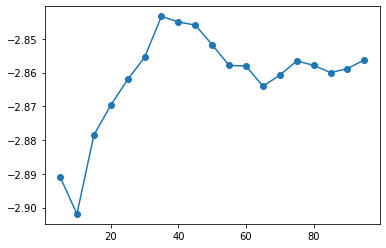

In [12]:
n_gw_fit_try = range(5,100,5)
n_gw_predict = 6
gw_index = 100


scores = []
for n_gw_fit in n_gw_fit_try:
    print(n_gw_fit)
    fit_data = select_n_gw_before(gw_index, n_gw_fit)

    model_team = create_and_fit_team_model(fit_data,
                                           df_X,
                                           teams=teams,
                                           verbose=False)

    validate_data = select_n_gw_from(gw_index, n_gw_predict)
    scores.append(model_team.log_score(validate_data))
    
plt.plot(n_gw_fit_try, scores, 'o-')

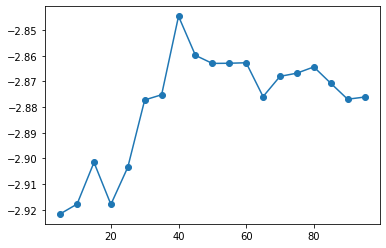

In [11]:
plt.plot(range(5,100,5), scores, 'o-')

In [6]:
model_team.log_score()

-2.8024764434898204

In [7]:
list(range(5,50,5))

[5, 10, 15, 20, 25, 30, 35, 40, 45]